## INSTALLING DEPENDENCIES

In [9]:
!pip install yfinance ta xgboost statsmodels scikit-learn keras tensorflow --quiet

## IMPORT LIBRARIES

In [13]:
import yfinance as yf #yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import ta #ta for analysis
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

## LOADING THE DATASET

In [16]:
ticker = "AAPL"  # AAPL is the chosen ticker, you may also try experimenting with TSLA, MSFT etc

# 10 year data
start_date = "2015-01-01"
end_date = "2024-12-31"

df = yf.download(ticker, start=start_date, end=end_date)

# Drop rows with NaN values
df.dropna(inplace=True)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.288578,24.757332,23.848704,24.746224,212818400
2015-01-05,23.604332,24.137513,23.417720,24.057535,257142000
2015-01-06,23.606554,23.866479,23.244435,23.668758,263188400
2015-01-07,23.937569,24.037539,23.704302,23.815381,160423600
2015-01-08,24.857304,24.915065,24.148618,24.266363,237458000


In [22]:
print("Shape:", df.shape)
print("Columns:", df.columns)
print("Index:", df.index)

Shape: (2515, 5)
Columns: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Index: DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19',
               '2024-12-20', '2024-12-23', '2024-12-24', '2024-12-26',
               '2024-12-27', '2024-12-30'],
              dtype='datetime64[ns]', name='Date', length=2515, freq=None)


## PRE-PROCESSING AND EDA

In [23]:
# Data types
print("\nData types:")
print(df.dtypes)

# Summary statistics
print("\nStatistical Summary:")
display(df.describe())


Data types:
Price   Ticker
Close   AAPL      float64
High    AAPL      float64
Low     AAPL      float64
Open    AAPL      float64
Volume  AAPL        int64
dtype: object

Statistical Summary:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03
mean,93.994613,94.907268,92.978800,93.906769,1.171176e+08
std,65.518476,66.112101,64.829415,65.435984,6.839566e+07
min,20.647457,20.951433,20.448617,20.569750,2.323470e+07
25%,35.277454,35.681949,34.917549,35.308424,7.108210e+07
50%,64.509293,64.859465,63.698889,64.267085,1.003845e+08
75%,150.535988,152.267275,148.515864,150.317850,1.426222e+08
max,258.396667,259.474086,257.010028,257.568678,6.488252e+08


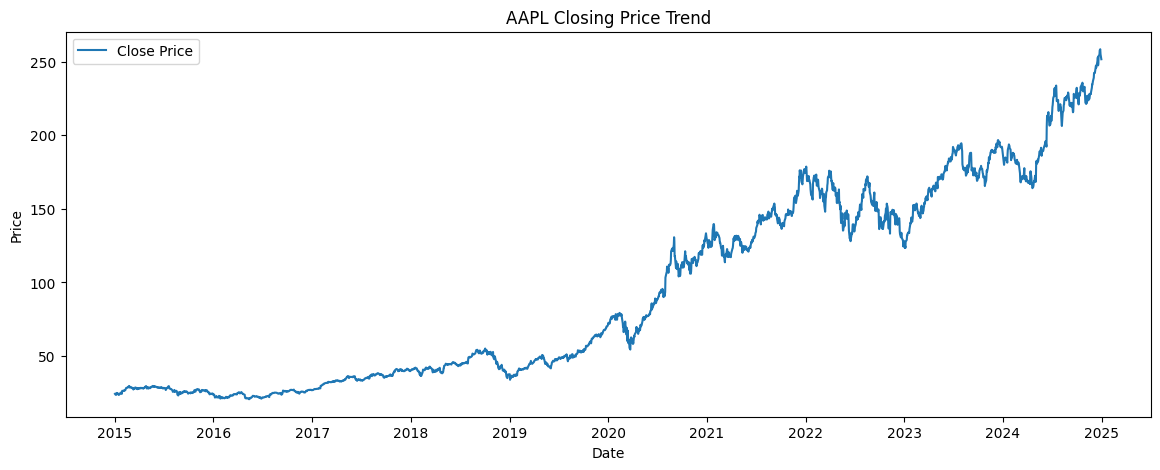

In [24]:
# Trends of Closing price
plt.figure(figsize=(14,5))
plt.plot(df['Close'], label='Closing Price')
plt.title(f'{ticker} Closing Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

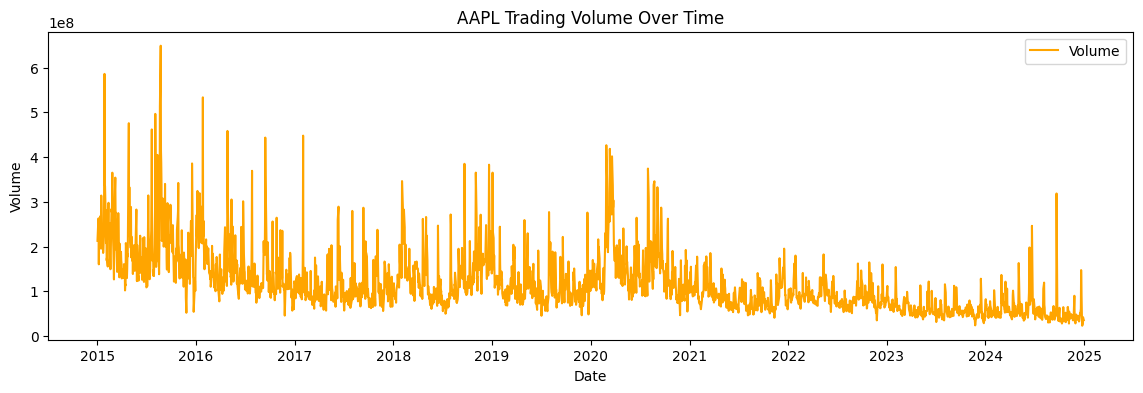

In [25]:
# Volume trend
plt.figure(figsize=(14,4))
plt.plot(df['Volume'], color='orange', label='Volume')
plt.title(f'{ticker} Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

## FEATURE ENGINEERING

In [27]:
'''For a typical stock price prediction pipeline, the feature engineering steps involve
  1. Simple Moving Average and Exponential Moving Average
  2. RSI (Relative Strength Index)
  3. MACD (Moving Average Convergence Divergence)
  4. Bollinger Bands (Upper and Lower)
  5. Lag Features
  6. Rolling Stats
  7. Target Variables
'''

close_series = df['Close'].squeeze()

# Moving Average, RSI and MACD
df['SMA_10'] = ta.trend.sma_indicator(close_series, window=10)
df['EMA_10'] = ta.trend.ema_indicator(close_series, window=10)
df['RSI'] = ta.momentum.rsi(close_series, window=14)
df['MACD'] = ta.trend.macd(close_series)

# Bollinger Bands
bb = ta.volatility.BollingerBands(close=close_series, window=20, window_dev=2)
df['BB_High'] = bb.bollinger_hband()
df['BB_Low'] = bb.bollinger_lband()

# Lag Features
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)

# Rolling Statistics
df['rolling_mean_5'] = df['Close'].rolling(window=5).mean()
df['rolling_std_5'] = df['Close'].rolling(window=5).std()

# Target variables
df['target_reg'] = df['Close'].shift(-1)  # for regression
df['target_class'] = (df['Close'].shift(-1) > df['Close']).astype(int)  # for classification

In [28]:
# Drop rows with any NaNs - these arise due to rolling, lag or target
df.dropna(inplace=True)
df.head()

Price,Close,High,Low,Open,Volume,SMA_10,EMA_10,RSI,MACD,BB_High,BB_Low,lag_1,lag_2,rolling_mean_5,rolling_std_5,target_reg,target_class
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,
2015-02-09,26.701777,26.728540,26.414061,26.440826,155559200,26.155938,26.167842,66.460478,0.634478,27.422652,23.144719,26.525581,26.750837,26.579710,0.155020,27.214752,1
2015-02-10,27.214752,27.243748,26.799908,26.802137,248034000,26.452776,26.358190,70.229639,0.681844,27.673455,23.188311,26.701777,26.525581,26.750841,0.275819,27.852638,1
2015-02-11,27.852638,27.861560,27.321815,27.382034,294247200,26.676332,26.629908,74.123842,0.762069,28.030319,23.168081,27.214752,26.701777,27.009117,0.535907,28.205032,1
2015-02-12,28.205032,28.432529,28.006531,28.115818,297898000,26.855371,26.916294,75.992188,0.844351,28.403632,23.175971,27.852638,27.214752,27.299956,0.722730,28.343317,1
2015-02-13,28.343317,28.387923,28.024377,28.387923,217088800,27.086894,27.175753,76.703053,0.910225,28.680438,23.360401,28.205032,27.852638,27.663503,0.692363,28.510592,1


## MODELS - TIME SERIES FORECASTING

In [46]:
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

train_size = int(len(df) * 0.8)
train, test = df['Close'].iloc[:train_size], df['Close'].iloc[train_size:]

# Build ARIMA model
model_arima = ARIMA(train, order=(5, 1, 0))
model_fit = model_arima.fit()

# Forecast - predict same length as test set
forecast = model_fit.forecast(steps=len(test))
df['arima_pred'] = np.nan
df['arima_pred'].iloc[train_size:] = forecast.values

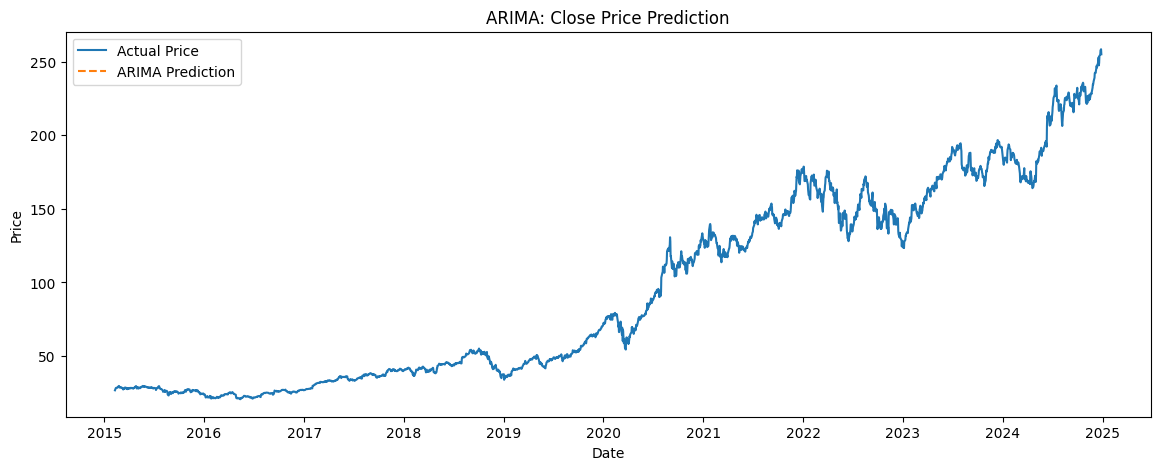

In [47]:
# Plot actual vs ARIMA predicted
plt.figure(figsize=(14,5))
plt.plot(df['Close'], label='Actual Price')
plt.plot(df['arima_pred'], label='ARIMA Prediction', linestyle='--')
plt.title('ARIMA: Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [48]:
# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math

rmse = math.sqrt(mean_squared_error(test, forecast))
print(f'ARIMA RMSE: {rmse:.2f}')
mse = mean_squared_error(test, forecast)
print(f'ARIMA MSE: {mse:.2f}')
mae = mean_absolute_error(test, forecast)
print(f'ARIMA MAE: {mae:.2f}')
mape = mean_absolute_percentage_error(test, forecast)
print(f'ARIMA MAPE: {mape:.2f}')

ARIMA RMSE: 69.71
ARIMA MSE: 4859.65
ARIMA MAE: 63.98
ARIMA MAPE: 0.32


In [49]:
# XGBOOST
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Define features and target
features = [
    'SMA_10', 'EMA_10', 'RSI', 'MACD', 'BB_High', 'BB_Low',
    'lag_1', 'lag_2', 'rolling_mean_5', 'rolling_std_5'
]
target = 'target_reg'

# Split (no shuffle)
X = df[features]
y = df[target]

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [50]:
# Train model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

df['xgb_pred'] = xgb_model.predict(X)

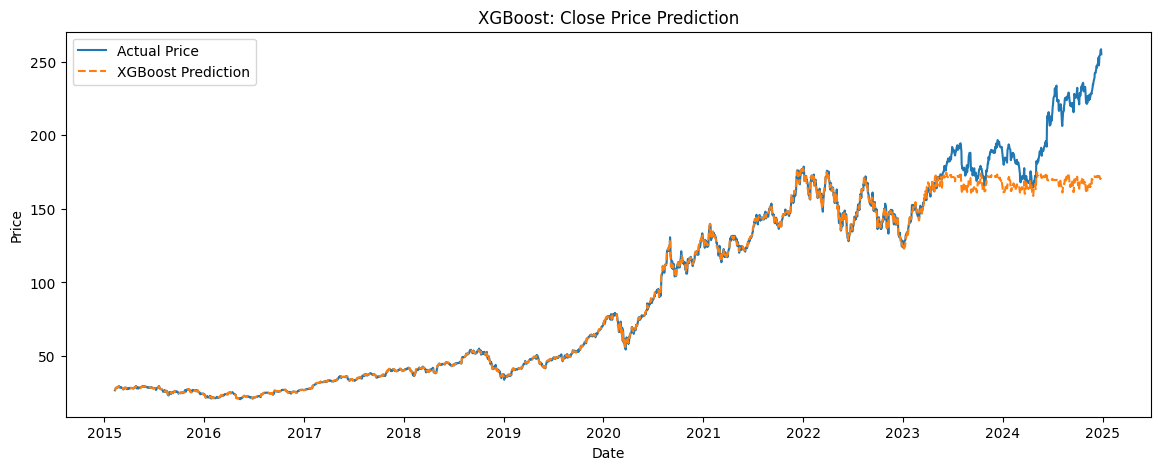

In [51]:
# Plot the prediction
plt.figure(figsize=(14,5))
plt.plot(df['Close'], label='Actual Price')
plt.plot(df['xgb_pred'], label='XGBoost Prediction', linestyle='--')
plt.title('XGBoost: Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [52]:
# Evaluation Metrics
rmse = math.sqrt(mean_squared_error(y_test, df['xgb_pred'].iloc[split_idx:]))
print(f'XGBoost RMSE: {rmse:.2f}')
mse = mean_squared_error(y_test, df['xgb_pred'].iloc[split_idx:])
print(f'XGBoost MSE: {mse:.2f}')
mae = mean_absolute_error(y_test, df['xgb_pred'].iloc[split_idx:])
print(f'XGBoost MAE: {mae:.2f}')
mape = mean_absolute_percentage_error(y_test, df['xgb_pred'].iloc[split_idx:])
print(f'XGBoost MAPE: {mape:.2f}')

XGBoost RMSE: 33.33
XGBoost MSE: 1110.65
XGBoost MAE: 24.07
XGBoost MAPE: 0.11


In [53]:
# LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

close_prices = df[['Close']].values
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

# Create sequences - 60 sequences
X_lstm, y_lstm = [], []
for i in range(60, len(scaled_close)-1):
    X_lstm.append(scaled_close[i-60:i])
    y_lstm.append(scaled_close[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split train test as 80/20
split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

In [54]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_lstm.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=0)

pred_lstm_scaled = model.predict(X_test_lstm)
pred_lstm = scaler.inverse_transform(pred_lstm_scaled)
y_test_lstm_actual = scaler.inverse_transform(y_test_lstm)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [55]:
# Evaluation Metrics
rmse = math.sqrt(mean_squared_error(y_test_lstm_actual, pred_lstm))
mse = mean_squared_error(y_test_lstm_actual, pred_lstm)
mae = mean_absolute_error(y_test_lstm_actual, pred_lstm)
mape = mean_absolute_percentage_error(y_test_lstm_actual, pred_lstm)

print(f'LSTM RMSE: {rmse:.2f}')
print(f'LSTM MSE: {mse:.2f}')
print(f'LSTM MAE: {mae:.2f}')
print(f'LSTM MAPE: {mape:.2f}')

LSTM RMSE: 6.14
LSTM MSE: 37.70
LSTM MAE: 4.85
LSTM MAPE: 0.02


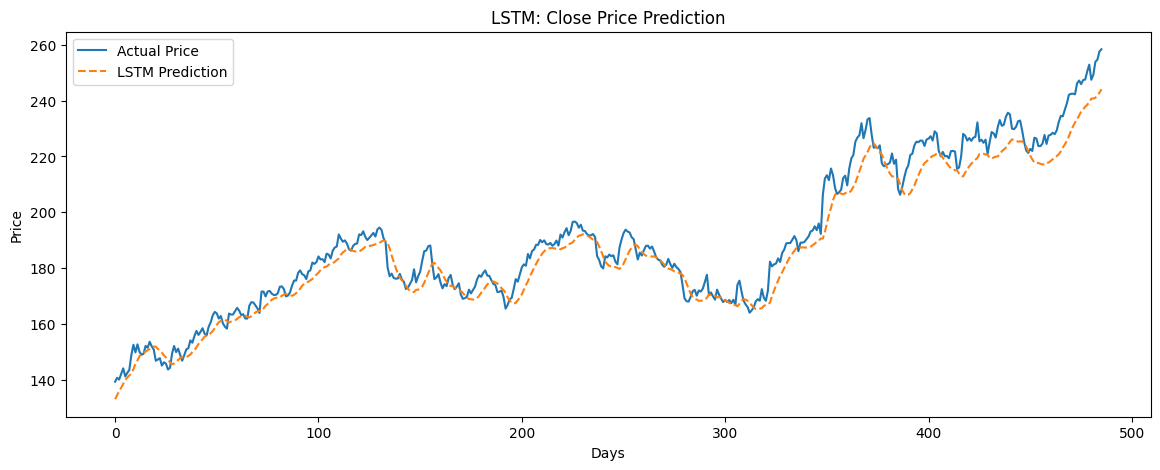

In [56]:
# Plot the predictions
plt.figure(figsize=(14,5))
plt.plot(y_test_lstm_actual, label='Actual Price')
plt.plot(pred_lstm, label='LSTM Prediction', linestyle='--')
plt.title('LSTM: Close Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

## IDENTIFY BUY/SELL SIGNALS

In [113]:
actual_test_close = close_prices[-len(y_test_lstm):]  # shape (X,)

# Create a new DataFrame for test portion as signal_df
signal_df = pd.DataFrame({
    'Date': df.index[-len(pred_lstm):],
    'Close': actual_test_close.flatten(),
    'Predicted': pred_lstm.flatten()
})

threshold = 0.01  # 10% threshold
signal_df['signal'] = 0

signal_df.loc[signal_df['Predicted'] > signal_df['Close'] * (1 + threshold), 'signal'] = 1   # Buy
signal_df.loc[signal_df['Predicted'] < signal_df['Close'] * (1 - threshold), 'signal'] = -1  # Sell

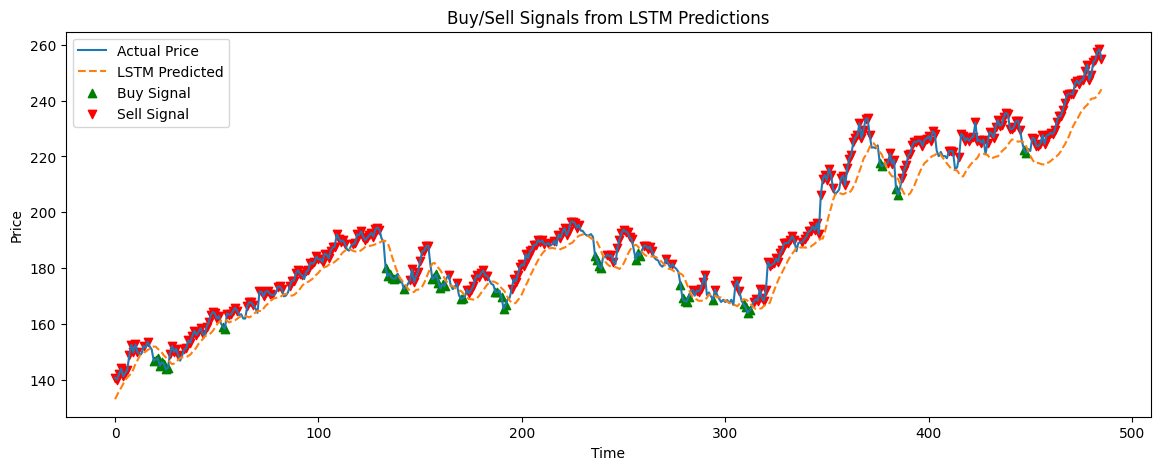

In [114]:
# Plot to see the Buy/Sell signals
plt.figure(figsize=(14,5))
plt.plot(signal_df['Close'], label='Actual Price')
plt.plot(signal_df['Predicted'], label='LSTM Predicted', linestyle='--')

plt.scatter(signal_df[signal_df['signal']==1].index,
            signal_df[signal_df['signal']==1]['Close'],
            marker='^', color='green', label='Buy Signal')

plt.scatter(signal_df[signal_df['signal']==-1].index,
            signal_df[signal_df['signal']==-1]['Close'],
            marker='v', color='red', label='Sell Signal')

plt.title("Buy/Sell Signals from LSTM Predictions")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

## BACKTESTING

In [115]:
initial_balance = 10000 # can change it
cash = initial_balance
position = 0
portfolio_value = []

for i in range(len(signal_df)):
    price = signal_df.loc[i, 'Close']
    signal = signal_df.loc[i, 'signal']

    # BUY
    if signal == 1 and cash > 0:
        position = cash / price
        cash = 0

    # SELL
    elif signal == -1 and position > 0:
        cash = position * price
        position = 0

    # Store the current portfolio value
    total = cash + (position * price)
    portfolio_value.append(total)

# Add to DataFrame
signal_df['Portfolio Value'] = portfolio_value

# Baseline: Buy & Hold from start
buy_hold = initial_balance * (signal_df['Close'] / signal_df['Close'].iloc[0])
signal_df['Buy & Hold'] = buy_hold

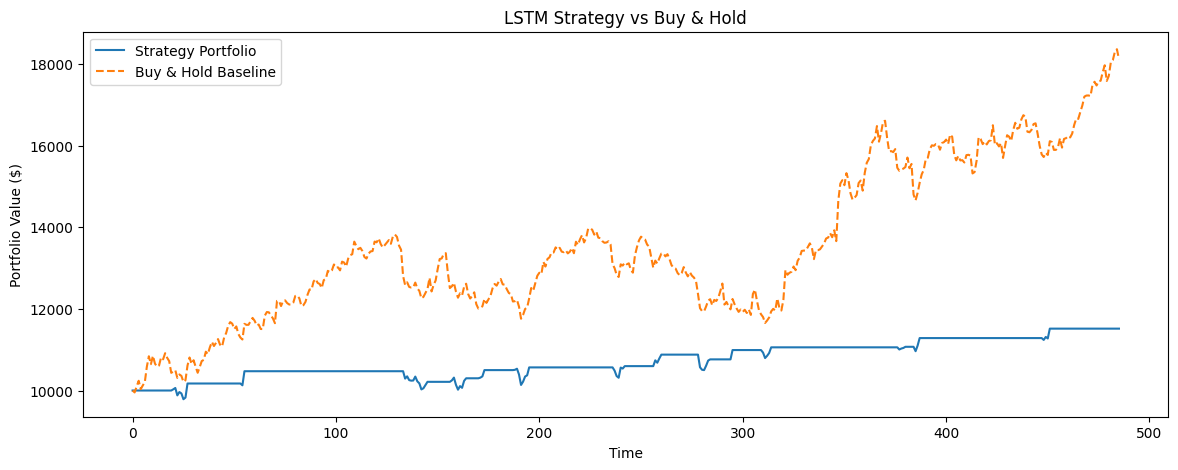

In [116]:
plt.figure(figsize=(14,5))
plt.plot(signal_df['Portfolio Value'], label='Strategy Portfolio')
plt.plot(signal_df['Buy & Hold'], label='Buy & Hold Baseline', linestyle='--')
plt.title("LSTM Strategy vs Buy & Hold")
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()

In [117]:
import numpy as np

# METRICS
returns = signal_df['Portfolio Value'].pct_change().dropna()

# Sharpe Ratio
sharpe = (returns.mean() / returns.std()) * np.sqrt(252)

# Sortino Ratio
downside_returns = returns[returns < 0]
sortino = (returns.mean() / downside_returns.std()) * np.sqrt(252)

# Max Drawdown
rolling_max = signal_df['Portfolio Value'].cummax()
drawdown = signal_df['Portfolio Value'] / rolling_max - 1
max_dd = drawdown.min()

# Cumulative Return
cumulative_return = (signal_df['Portfolio Value'].iloc[-1] / signal_df['Portfolio Value'].iloc[0]) - 1

# Volatility
volatility = returns.std() * np.sqrt(252)

# Accuracy: Direction match between actual and predicted price
signal_df['actual_change'] = signal_df['Close'].diff()
signal_df['predicted_change'] = signal_df['Predicted'].diff()
direction_accuracy = (np.sign(signal_df['actual_change'][1:]) == np.sign(signal_df['predicted_change'][1:])).mean()

# Print metrics
print(f"Cumulative Return: {cumulative_return*100:.2f}%")
print(f"Max Drawdown: {max_dd*100:.2f}%")
print(f"Volatility: {volatility:.4f}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Direction Accuracy: {direction_accuracy*100:.2f}%")

Cumulative Return: 15.16%
Max Drawdown: -4.32%
Volatility: 0.0749
Sharpe Ratio: 1.02
Sortino Ratio: 0.69
Direction Accuracy: 51.13%


## VISUALIZATIONS

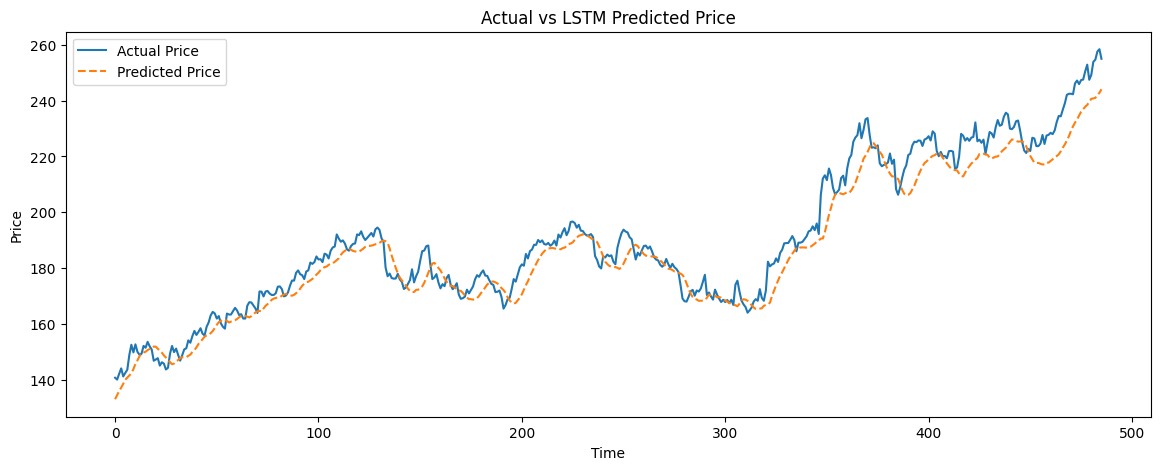

In [119]:
# Price vs Predicted
plt.figure(figsize=(14,5))
plt.plot(signal_df['Close'], label='Actual Price')
plt.plot(signal_df['Predicted'], label='Predicted Price', linestyle='--')
plt.title("Actual vs LSTM Predicted Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

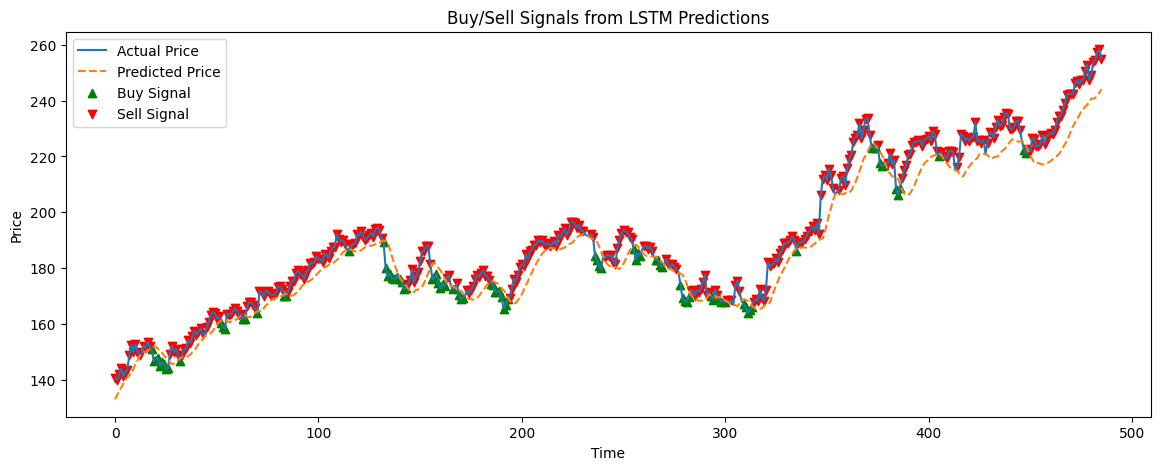

In [120]:
# Buy/Sell Signal Chart
plt.figure(figsize=(14,5))
plt.plot(signal_df['Close'], label='Actual Price')
plt.plot(signal_df['Predicted'], label='Predicted Price', linestyle='--')

plt.scatter(signal_df[signal_df['signal']==1].index,
            signal_df[signal_df['signal']==1]['Close'],
            marker='^', color='green', label='Buy Signal')

plt.scatter(signal_df[signal_df['signal']==-1].index,
            signal_df[signal_df['signal']==-1]['Close'],
            marker='v', color='red', label='Sell Signal')

plt.title("Buy/Sell Signals from LSTM Predictions")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

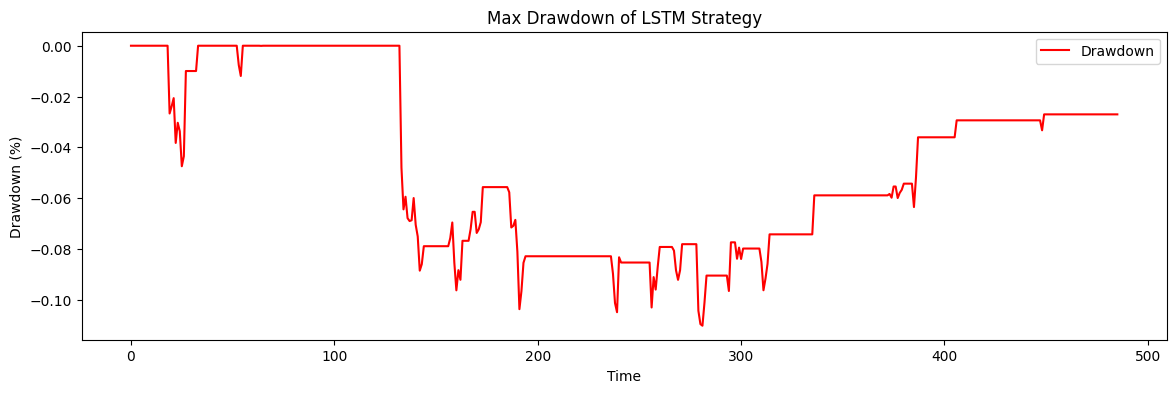

In [121]:
# Max Drawdown chart
plt.figure(figsize=(14,4))
drawdown = signal_df['Portfolio Value'] / signal_df['Portfolio Value'].cummax() - 1
plt.plot(drawdown, color='red', label='Drawdown')
plt.title("Max Drawdown of LSTM Strategy")
plt.xlabel("Time")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.show()

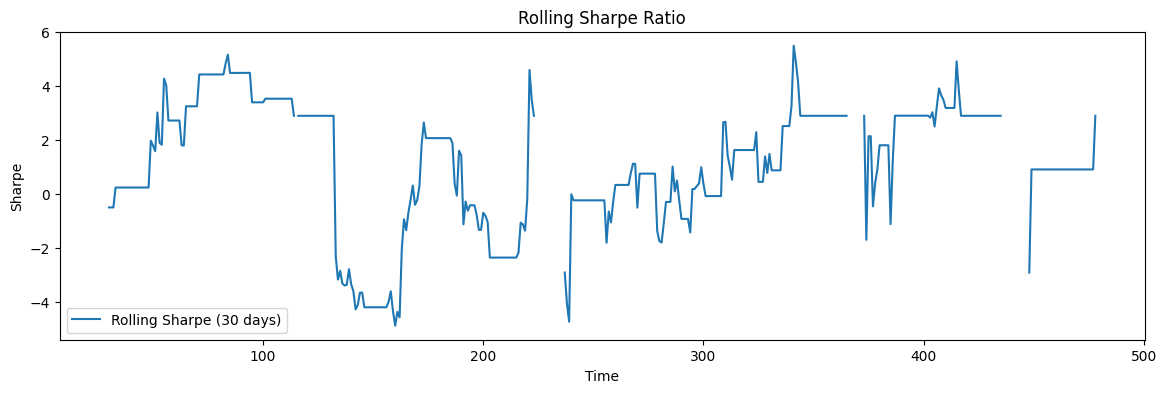

In [122]:
# Rolling Sharpe Ratio
rolling_returns = signal_df['Portfolio Value'].pct_change()
rolling_sharpe = (rolling_returns.rolling(window=30).mean() /
                  rolling_returns.rolling(window=30).std()) * np.sqrt(252)

plt.figure(figsize=(14,4))
plt.plot(rolling_sharpe, label='Rolling Sharpe (30 days)')
plt.title("Rolling Sharpe Ratio")
plt.xlabel("Time")
plt.ylabel("Sharpe")
plt.legend()
plt.show()